<a href="https://colab.research.google.com/github/carol1521/2-tier-Argumentation-Framework/blob/main/Undercut_Relationship_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [ ]:
!pip install scikit-plot

In [ ]:
import nltk, os, gensim
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, f1_score, precision_score, recall_score
import scikitplot.plotters as skplt

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten,TimeDistributed,LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

# functions from https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec=None):
        self.word2vec = word2vec
        if not self.word2vec:
            self.word2vec = gensim.models.Word2Vec.load('/content/drive/MyDrive/Yan/w2vmodelu')
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(self.word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        emb = np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

        return np.mean(emb, axis = 0)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model
#w2vec = get_word2vec(MySentences(str([test])), '/content/drive/MyDrive/Yan/w2vmodelu')

def evaluate_plt(x_test, y_test, clf):
    # print probas
    y_preds=clf.predict(x_test)
    
    #pred_indices = np.argmax(probas, axis=1)
    #classes = np.unique(y)
    #preds = classes[pred_indices]
    #print('Train Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y_test, y_preds)))
    print("f1_score:{}".format(f1_score(y_test, y_preds)))
    print("precision_score:{}".format(precision_score(y_test, y_preds)))
    print("recall_score:{}".format(recall_score(y_test, y_preds)))
    print("loss:{}".format(log_loss(y_test, y_preds)))
    skplt.plot_confusion_matrix(y_test, y_preds)
    return clf


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# relationship_detection

## reading data

In [ ]:
import numpy as np
import pandas as pd
import string
import nltk
from sklearn.linear_model import LogisticRegression
#from utils import MyTokenizer, MySentences, MeanEmbeddingVectorizer, evaluate_train

In [ ]:
claimDF = pd.read_excel('/content/drive/MyDrive/Yan/2014_ibm_Claim_Evidence_UR_data_c.xlsx')
#claimDF = pd.read_csv('/content/drive/MyDrive/Yan/2014_ibm_Claim_Evidence_UR_data_c.csv',encoding= 'unicode_escape')

In [ ]:
claimDF[:1].T

,0
claims,exposure to violent video games causes at leas...
evidences,several major studies by groups such as The Ha...
undercut_Relation,1


In [ ]:
# 1040
# create dataset
#test = claimDF[[ 'claims', 'evidences', 'undercut_Relation']]
texts = claimDF[['claims','evidences','undercut_Relation']]



In [ ]:
from nltk.text import Text
from sklearn.model_selection import train_test_split
train, test = train_test_split(texts, test_size=0.2)

In [ ]:
train['evidences'][20]

In [ ]:
train['claims'][20]

## embedding

In [ ]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(None)

train['train_claim_token'] = train['claims'].apply(lambda x: nltk.word_tokenize(str(x).lower()))
train['train_claim_mean']= train['train_claim_token'].apply(lambda x: mean_embedding_vectorizer.transform(str(x)))

test['test_claim_token'] = test['claims'].apply(lambda x: nltk.word_tokenize(str(x).lower()))
test['test_claim_mean']= test['test_claim_token'].apply(lambda x: mean_embedding_vectorizer.transform(str(x)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
train['train_evidence_token'] = train['evidences'].apply(lambda x: nltk.word_tokenize(str(x).lower()))
train['train_evidence_mean']= train['train_evidence_token'].apply(lambda x: mean_embedding_vectorizer.transform(str(x)))

test['test_evidence_token'] = test['evidences'].apply(lambda x: nltk.word_tokenize(str(x).lower()))
test['test_evidence_mean']= test['test_evidence_token'].apply(lambda x: mean_embedding_vectorizer.transform(str(x)))
train['train_final_embedding'] = train.apply(lambda x: [np.append(x['train_claim_mean'], x['train_evidence_mean'])], axis=1)
test['test_final_embedding'] = test.apply(lambda x: [np.append(x['test_claim_mean'], x['test_evidence_mean'])], axis=1)
train['train_relation'] = train['undercut_Relation'].apply(lambda x: 0 if x == 0 else 1)
test['test_relation'] = test['undercut_Relation'].apply(lambda x: 0 if x == 0 else 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
#from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

x_train = np.vstack(train['train_final_embedding'].values)
y_train = train['train_relation'].values.ravel()

x_test = np.vstack(test['test_final_embedding'].values)
y_test = test['test_relation'].values.ravel()


In [ ]:
y_test.shape

(208,)

## Randomforest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:

clf0=RandomForestClassifier(oob_score=True,random_state=10)
clf0.fit(x_train,y_train)

print(clf0.oob_score_)
print("accuracy:%f"%clf0.oob_score_)
y_pred=clf0.predict(x_test)

0.8641826923076923
accuracy:0.864183


In [ ]:
param_test1 = {"n_estimators":range(1,101,5)}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_test1,
                        scoring='roc_auc',cv=10)
gsearch1.fit(x_train,y_train)

#print(gsearch1.grid_scores_)
print(gsearch1.best_params_)
print("best accuracy:%f" % gsearch1.best_score_)

{'n_estimators': 61}
best accuracy:0.936425


In [ ]:
param_test2 = {"max_features":range(1,11,1)}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(n_estimators=86,
                        random_state=10),
                        param_grid = param_test2,scoring='roc_auc',cv=10)
gsearch1.fit(x_train,y_train)
#print(gsearch1.grid_scores_)
print(gsearch1.best_params_)
print('best accuracy:%f' % gsearch1.best_score_)

{'max_features': 10}
best accuracy:0.935460


In [ ]:
uclf = RandomForestClassifier(n_estimators=61,max_features=10,
                             oob_score=True,random_state=10)
uclf.fit(x_train,y_train)
#print(clf0.oob_score_)
print("accuracy: %f" % uclf.oob_score_)

accuracy: 0.867788


In [ ]:
#save model
f = open('/content/drive/MyDrive/Yan/saved_model/uclf.pickle','wb')
pickle.dump(uclf,f)
f.close()

In [ ]:
f = open('/content/drive/MyDrive/Yan/saved_model/uclf.pickle','rb')
uclf1 = pickle.load(f)
f.close()
predictions=uclf1.predict(x_test)
#print(predictions)

Accuracy: 0.8798076923076923
f1_score:0.9158249158249158
precision_score:0.8831168831168831
recall_score:0.951048951048951
loss:4.151364435704378


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


RandomForestClassifier(max_features=10, n_estimators=61, oob_score=True,
                       random_state=10)

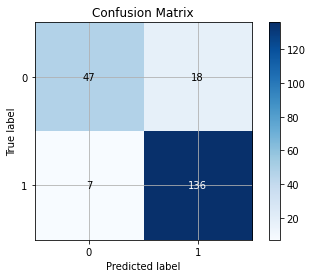

In [ ]:
#randomforestU
evaluate_plt(x_test,y_test,uclf1)

## LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_logist0 = LogisticRegression(random_state=0).fit(x_train,y_train)

print(clf_logist0.score(x_test,y_test))
print("accuracy:%f"%clf_logist0.score(x_test,y_test))
y_pred_logist=clf_logist0.predict(x_test)

0.6875
accuracy:0.687500


In [ ]:
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
print("f1_score:",f1_score(y_test, y_pred_logist))
print("accuracy_score",accuracy_score(y_test, y_pred_logist))
print("precision_score",precision_score(y_test, y_pred_logist))
print("recall_score",recall_score(y_test, y_pred_logist))

f1_score: 0.8148148148148148
accuracy_score 0.6875
precision_score 0.6875
recall_score 1.0


In [ ]:
best_ting = {
    'max_iter':[10,20,40,60,80,100],
    'C':[0.01,0.1,1,10]
}

In [ ]:
param_test=GridSearchCV(LogisticRegression(random_state=0),best_ting,cv=5)

In [ ]:
param_test.fit(x_train,y_train)

In [ ]:
print(param_test.best_params_)

{'C': 0.01, 'max_iter': 10}


In [ ]:
uclf_logist=LogisticRegression(max_iter=10,C=0.1).fit(x_train,y_train)

In [ ]:
#save model
f = open('/content/drive/MyDrive/Yan/saved_model/uclf_logist.pickle','wb')
pickle.dump(uclf_logist,f)
f.close()

In [ ]:
f = open('/content/drive/MyDrive/Yan/saved_model/uclf_logist.pickle','rb')
uclf_logist1 = pickle.load(f)
f.close()
#predictions=uclf1.predict(x_test)
#print(predictions)

Accuracy: 0.6875
f1_score:0.8148148148148148
precision_score:0.6875
recall_score:1.0
loss:10.793617497606524


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


LogisticRegression(C=0.1, max_iter=10)

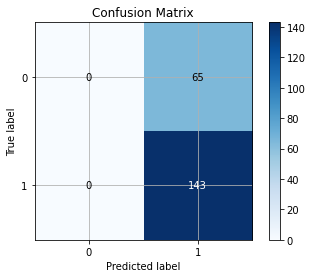

In [ ]:
#logisticregressionU
evaluate_plt(x_test,y_test,uclf_logist1 )

## predicted result

In [ ]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 7.4 MB/s 


In [ ]:
predicted_result_u = {}
predicted_result_u['result'] = []
# predict_eval = clf1.predict(x_test).tolist()

for claims, evidences, predicted_label in zip(test['claims'], test['evidences'], predictions):
    if predicted_label == 1:
        predicted_result_u['result'].append({
            "predicted_claims": claims,
            "predicted_evidences": evidences,
            "predicted_label": predicted_label
        })

In [ ]:
#predict != truth
predicted_miss_u ={}
predicted_miss_u ['miss_result'] =[]

for claims, evidences, predicted_label, truth in zip(test['claims'], test['evidences'], predictions, y_test):
    if predicted_label != truth:
        predicted_miss_u['miss_result'].append({
            "predicted_claims": claims,
            "predicted_evidences": evidences,
            "predicted_label": predicted_label,
            "truth" : truth
        })


In [ ]:
#Only predict=1 truth=1
predicted_true_u = {}
predicted_true_u['true_result'] = []

for claims, evidences, predicted_label, truth in zip(test['claims'], test['evidences'], predictions, y_test):
    if predicted_label == 1 and truth == 1:
        predicted_true_u['true_result'].append({
            "predicted_claims": claims,
            "predicted_evidences": evidences,
            "predicted_label": predicted_label,
            "truth" : truth
        })

In [ ]:
len(predicted_true_u['true_result'])

138

In [ ]:
len(predicted_miss_u ['miss_result'])

25

In [ ]:
data = predicted_result_u['result']
df = pd.DataFrame(data)
writer = pd.ExcelWriter('/content/drive/MyDrive/Yan/predicted_result_u.xlsx', engine='xlsxwriter')
df.to_excel(writer, index = False )
writer.save()

In [ ]:
data =predicted_true_u['true_result']
df = pd.DataFrame(data)
writer = pd.ExcelWriter('/content/drive/MyDrive/Yan/predicted_true_u.xlsx', engine='xlsxwriter')
df.to_excel(writer, index = False )
writer.save()

In [ ]:
data =predicted_miss_u ['miss_result']
df = pd.DataFrame(data)
writer = pd.ExcelWriter('/content/drive/MyDrive/Yan/predicted_miss_u.xlsx', engine='xlsxwriter')
df.to_excel(writer, index = False )
writer.save()

In [ ]:
len(predicted_true_u['true_result'])

136